In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("data/csv/data.csv")

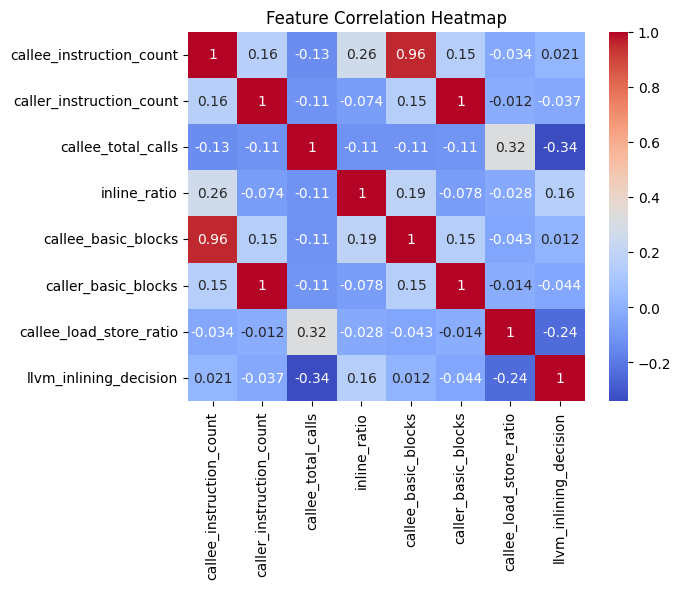

In [43]:
# Feature Correlation Heatmap
corr_df = df.drop(
    columns=[
        "callee_name",
        "caller_name",
        "callee_is_recursive",
        "callee_marked_inline",
        "callee_arg_count",
    ]
).corr()
sns.heatmap(corr_df, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Feature Correlation Heatmap
The feature correlation heatmap reveals a couple of interesting correlations:

## Callee Total Calls and Load Store Ratio
Callee total calls and load store ratio have a the strongest correlation with inlining decisions out of the feature set. These two features are likely used by LLVM's inlining heuristics and are therefore good candidate features for the model.

## Inline Ratio
Inline ratio shows a tiny positive correlation with inlining decisions. It may help in conjunction with the callee total calls and load store ratio to improve the model's performance.

# Instruction Count and Basic Block Count
Callee and caller instruction count are highly correlated (0.96 and 1 respectively) we will drop basic block count for both callee and caller to avoid multicollinearity.


<Figure size 1000x600 with 0 Axes>

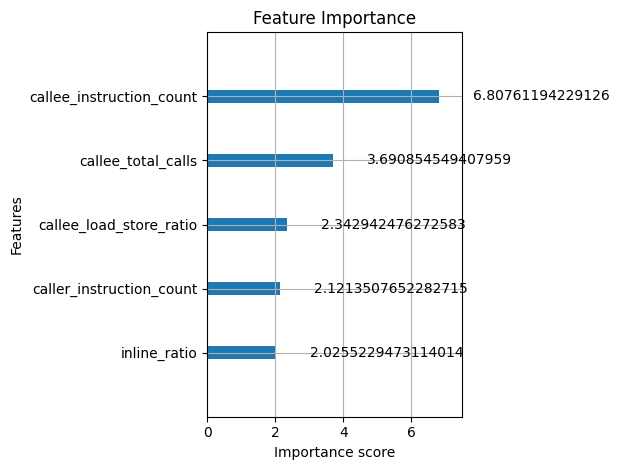

In [44]:
from xgboost import XGBClassifier, plot_importance

# drop columns we have already ruled out as features
# also drop string columns
# callee_is_recursive, callee_arg_count, and callee_marked_inline are dropped because we haven't found a good way to mine this data yet
# TODO: handle callee_is_recursive
# TODO: handle callee_arg_count
# TODO: handle callee_marked_inline
x = df.drop(
    columns=[
        "callee_name",
        "caller_name",
        "callee_is_recursive",
        "llvm_inlining_decision",
        "callee_arg_count",
        "callee_basic_blocks",
        "caller_basic_blocks",
        "callee_marked_inline"
    ]
)

# target column
y = df["llvm_inlining_decision"].astype(int)

# Train the model
model = XGBClassifier(eval_metric="logloss")
model.fit(x, y)

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=20, importance_type="gain")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


# Feature Importance
The feature importance plot shows that our most important features are callee instruction count, callee total calls, callee load store ratio, caller instruction count, and the inlining ratio. The importance scores are based on the average gain reflecting how much each feature improved the model's decision making. 

## Callee Instruction Count
Callee instruction count is by far the most important feature with an importance score of ~6.81. This suggests the number of instructions in the callee function strongly influences the inlining decision. This could be due to the fact that large functions are more expensive to inline and are therefore less likely to be inlined.

## Callee Total Calls
Callee total calls have an importance score of ~3.69 also playing a significant role in the inlining decision. Heavily called functions are more scrutinized during inlining decisions because inlining them could lead to bloat due to increased binary size.

## Callee Load Store Ratio
The callee load store ratio contributes moderately (~2.34) to the inlining decision. Functions with high memory access intensity are better left alone because their performance is mostly memory bound and therefore inlining will only lead to larger binaries.

## Caller Instruction Count
Caller instruction count has an importance score of ~2.12 indicating that it has moderate influence on the inlining decision. This could indicate that inlining calls in complex callers is disruptive to the caller's performance because of the increase in instruction count for an already large function.

## Inlining Ratio
Inlining ratio has an importance score of ~2.03 and seems to redundant and not contribute to the inlining decision. Inline ratio is (callee instruction count / caller instruction count) and has a moderate correlation with callee instruction count, it may be better to drop it.

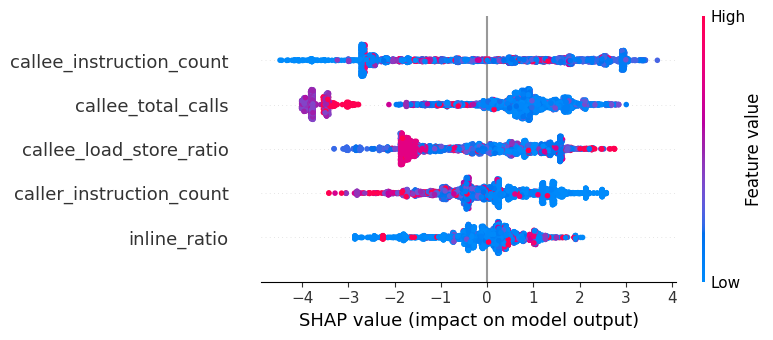

In [45]:
import shap

# create a SHAP explainer
explainer = shap.Explainer(model, x)

# calculate SHAP values for the test set
shap_values = explainer(x)

# create a SHAP summary plot
shap.summary_plot(shap_values, x)

plt.show()

# SHAP Summary Plot
This plot illustrates the impact of each feature on the model's inlining prediction. Each point represents a sample; position on the x-axis shows how much the feature influenced the prediction, and color reflects the feature's value (red = high, blue = low).

## Callee Instruction Count
The results for callee instruction count yield interesting results. The majority of red points are clustered to the left side of the plot indicating large functions are less likely to be inlined, this is consistent with common compiler heuristics. The blue points have a large cluster to the left and a smaller cluster to the right, indicating smaller functions are a more nuanced case for inlining.

## Callee Total Calls
The results for callee total calls is decisive. Hot functions (many calls) are far less likely to be inlined, this follows with our intuition that inlining hot functions will lead to bloat and performance degradation.

## Callee Load Store Ratio
Again the results for callee load store ratio are consistent with our intuition. Functions with high memory access intensity are better left alone, their performance is mostly memory bound and inlining them will only lead to larger binaries.

## Caller Instruction Count
These results indicate that larger callers are less likely to have their callees inlined, while smaller callers are slightly more likely to have their callees inlined.

## Inlining Ratio
The results for inlining ratio are very noisy and indicate that inline ratio is not a valuable feature for the model. 